In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
import seaborn as sns

# Read the pickled DataFrame
with open('data/consolidated_pat_tbl.pickle', 'rb') as file:
    consolidated_pat_tbl = pickle.load(file)

# QC
pd.get_dummies(consolidated_pat_tbl['race']).sum().sum() == consolidated_pat_tbl['subject_id'].nunique()

# Cast as integer
for col in consolidated_pat_tbl.columns:
    if col != 'race':
        consolidated_pat_tbl[col] = consolidated_pat_tbl[col].astype('float64')

In [2]:
# OneHotEncode race (ethnicity)!
encoder = OneHotEncoder(sparse_output=False)
race_enc = encoder.fit_transform(consolidated_pat_tbl[['race']])
mod_df = consolidated_pat_tbl.drop('race' , axis = 1)
mod_df = pd.concat([mod_df , pd.DataFrame(race_enc)] , axis = 1)

In [3]:
def train_test_splitter(df , test_size = 0.2 , val_size = 0.2 , duration_col = 'futime' , event_col = 'death'):
    df_test = df.sample(frac=test_size)
    df_train = df.drop(df_test.index)

    df_val = df_train.sample(frac=val_size)
    df_train = df_train.drop(df_val.index)

    return df_train , df_val , df_test

df_train , df_test , df_val = train_test_splitter(mod_df)

In [4]:
def _preprocess_stuff(df):
    _columns = df.columns.astype('str')
    df.columns = _columns

    # Imputation
    imputer = SimpleImputer(strategy = 'most_frequent')
    df = pd.DataFrame(imputer.fit_transform(df) , columns = _columns)

    # Check for null
    assert np.round(df.notnull().sum()/len(df)).sum() == df.shape[1]

    # name change
    df.rename(columns = {'50907':'cholesterol' , '50983':'sodium' , '51133':'lymphocyte' , '51222':'hemoglobin'} , inplace = True)

    return df

# use on train test val data
df_train = _preprocess_stuff(df_train)
df_test = _preprocess_stuff(df_test)
df_val = _preprocess_stuff(df_val)

In [13]:
# Scaling
scaler = StandardScaler()
scaled_columns = [
    'cholesterol', 'sodium', 'lymphocyte', 'hemoglobin',
    'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp'
    ]

unscaled_columns = ['acebutolol', 'amlodipine', 'atenolol', 'benazepril', 'candesartan',
    'captopril', 'diltiazem', 'felodipine', 'irbesartan', 'lisinopril',
    'moexipril', 'nadolol', 'nebivolol', 'nicardipine', 'nifedipine',
    'olmesartan', 'propranolol', 'quinapril', 'ramipril', 'telmisartan',
    'trandolapril', 'valsartan', 'verapamil', '0' ,'1' ,'2' ,'3' ,'4' ,'5' ,'time_to_event','death']

scale = [([col], StandardScaler()) for col in scaled_columns]
no_scale = [(col, None) for col in unscaled_columns]

x_mapper = DataFrameMapper(scale + no_scale)

# scale train test val data
x_train = pd.DataFrame(x_mapper.fit_transform(df_train).astype('float32') , columns = scaled_columns + unscaled_columns)
x_val = pd.DataFrame(x_mapper.transform(df_val).astype('float32') , columns = scaled_columns + unscaled_columns)
x_test = pd.DataFrame(x_mapper.transform(df_test).astype('float32') , columns = scaled_columns + unscaled_columns)

In [19]:
def check_var(df):
    zero_var_cols = []
    # Check which columns have zero variance
    for _col in df.columns[:-2]:
        var = df[_col].var()
        if var == 0:
            zero_var_cols.append(_col)
    return zero_var_cols

zero_var_cols = check_var(x_train)

# Drop the cols
x_train.drop(zero_var_cols, axis = 1, inplace = True)
x_test.drop(zero_var_cols, axis = 1, inplace = True)
x_val.drop(zero_var_cols, axis = 1, inplace = True)

In [20]:
# Pickle the DataFrame
with open('data/x_train.pickle', 'wb') as file:
    pickle.dump(x_train, file)

with open('data/x_val.pickle', 'wb') as file:
    pickle.dump(x_val, file)

with open('data/x_test.pickle', 'wb') as file:
    pickle.dump(x_test, file)

<Axes: >

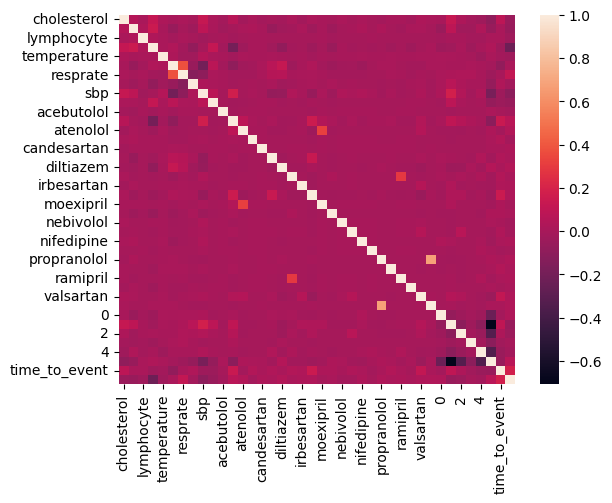

In [21]:
sns.heatmap(x_train.corr())